In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns; sns.set()

from sklearn import cluster, linear_model
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import pairwise_distances_argmin

from sklearn.cluster import AgglomerativeClustering
import scipy.cluster.hierarchy as shc

from kmodes.kmodes import KModes
from yellowbrick.cluster import KElbowVisualizer

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, cross_validate, KFold

In [ ]:
from keras.models import Model
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization
from keras.optimizers import RMSprop
from keras import regularizers

# Discovering structure in the data

In [2]:
# Read the data
features = pd.read_csv('./medical/historical_X.dat', header=None, sep=" ").values
actions = pd.read_csv('./medical/historical_A.dat', header=None, sep=" ").values
outcome = pd.read_csv('./medical/historical_Y.dat', header=None, sep=" ").values
observations = features[:, :128]
labels = features[:,128] + features[:,129]*2

In [3]:
symptoms = np.append(observations, labels[:,None], 1)

In [4]:
symptoms_true = symptoms[np.where(symptoms[:,128] != 0)]
symptoms_false = symptoms[np.where(symptoms[:,128] == 0)]

print(symptoms_true.shape)
print(symptoms_false.shape)

(5168, 129)
(4832, 129)


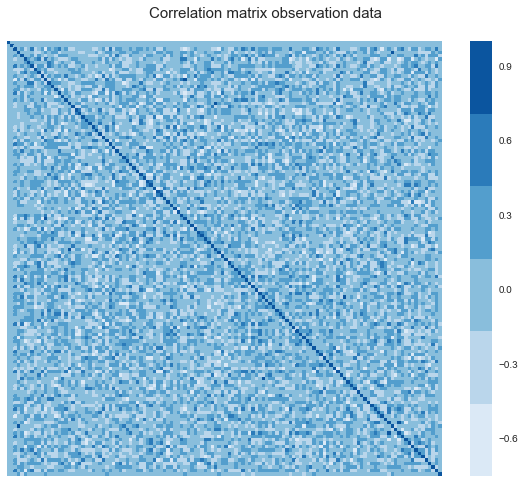

In [5]:
obs = pd.DataFrame(observations)
corr = obs.corr()

f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap = sns.color_palette('Blues'), #cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax, xticklabels = False, yticklabels = False)
plt.suptitle('Correlation matrix observation data', fontsize=15, y=0.94)
f.savefig('./Images/correlation_matrix.png')

We want the dendrogram of the observations data only.

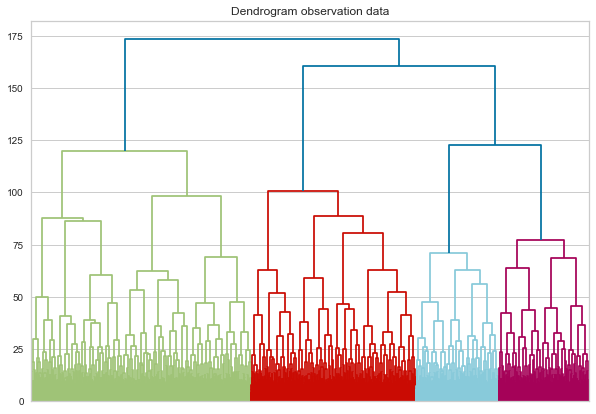

In [6]:
plt.figure(figsize=(10, 7))
plt.title("Dendrogram observation data")
dend = shc.dendrogram(shc.linkage(observations, method='ward'))
plt.xticks([])
plt.savefig('Images/dendrogram_observations')
plt.show()

We can also have a look at the elbow plot. We use KModes here instead of KMeans, which is suited for categorical data. The 'Cao' method uses an intitialization based on density.

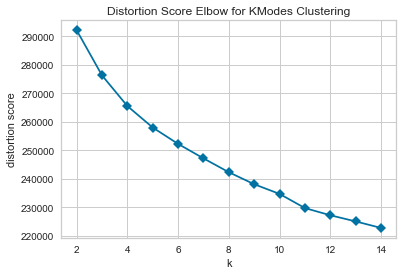

In [7]:
model = KModes(init='Cao', n_jobs=-1, verbose = 1)
visualizer = KElbowVisualizer(model, k=(2,15), timings = False, locate_elbow = False)
visualizer.fit(observations)        # Fit the data to the visualizer
visualizer.show(outpath = "Images/kelbow_kmodes.png")

In [8]:
k = 4

In [10]:
km = KModes(n_clusters=k, init='Cao', verbose=0)

clus = km.fit_predict(observations)

In [11]:
obs_clusters = np.append(observations, clus[:,None], 1)

In [12]:
obs_clusters = np.append(obs_clusters, labels[:,None], 1)

In [13]:
obs_clusters.shape

# last column (130) is labels
# 129 is clusters 

(10000, 130)

In [14]:
symptoms_true = obs_clusters[np.where(obs_clusters[:,129] != 0)]
symptoms_false = obs_clusters[np.where(obs_clusters[:,129] == 0)]

In [15]:
clusters_no_symp = symptoms_false[:,128]
clusters_symp = symptoms_true[:,128]

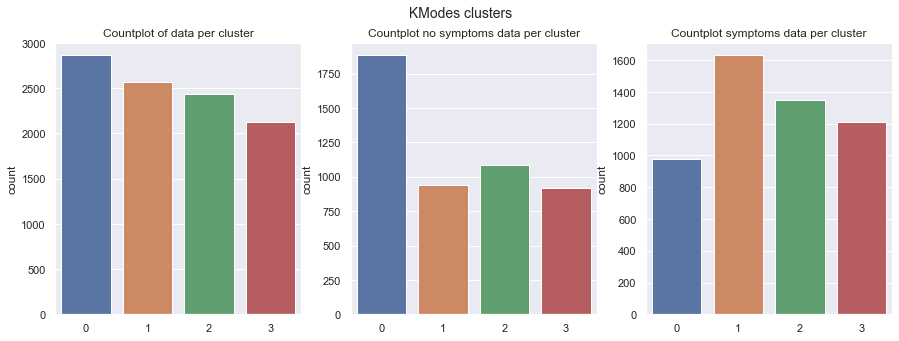

In [12]:
fig1, ax = plt.subplots(figsize = (15, 5), ncols = 3)
sns.countplot(clus, ax = ax[0])
sns.countplot(clusters_no_symp, ax = ax[1])
sns.countplot(clusters_symp, ax = ax[2])

fig1.suptitle("KModes clusters", fontsize=14)
ax[0].set_title('Countplot of data per cluster')
ax[1].set_title('Countplot no symptoms data per cluster')
ax[2].set_title('Countplot symptoms data per cluster')

fig1.savefig('Images/KModes_clusters_countplots')

plt.show()

### FOR SYMPTOMS = TRUE

In [16]:
k = 3

obs_symp_true = symptoms_true[:,:128]
labels_symp_true = symptoms_true[:,128]

In [17]:
km = KModes(n_clusters=k, init='Cao', verbose=0)

clus1 = km.fit_predict(obs_symp_true)

In [9]:
symp_clusters = np.append(obs_symp_true, clus1[:,None], 1)
symp_clusters = np.append(symp_clusters, labels_symp_true[:,None], 1)

In [10]:
# symp_clusters[:,129] zijn de symptomen, 
# symp_clusters[:,128] de clusters

symp_clusters.shape

(5168, 130)

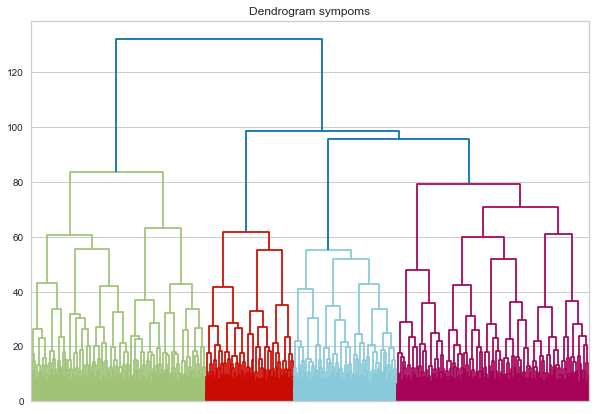

In [18]:
plt.figure(figsize=(10, 7))
plt.title("Dendrogram sympoms")
dend = shc.dendrogram(shc.linkage(obs_symp_true, method='ward'))
plt.xticks([])
plt.savefig('Images/dendrogram_symptoms')
plt.show()

In [11]:
symptom_a = symp_clusters[np.where(symp_clusters[:,129] == 1)]
symptom_b = symp_clusters[np.where(symp_clusters[:,129] == 2)]
symptom_both = symp_clusters[np.where(symp_clusters[:,129] == 3)]

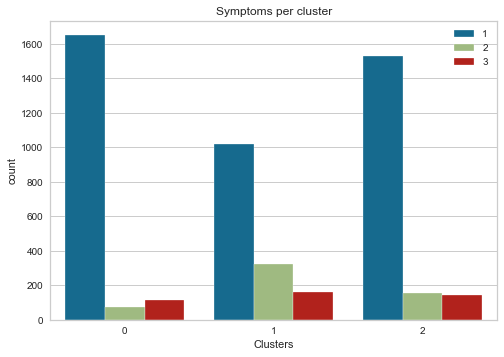

In [12]:
g = sns.countplot(x = symp_clusters[:,128], hue = symp_clusters[:,129])
#plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('Symptoms per cluster')
plt.xlabel('Clusters')
plt.savefig('Images/Symp_per_cluster')
plt.show()

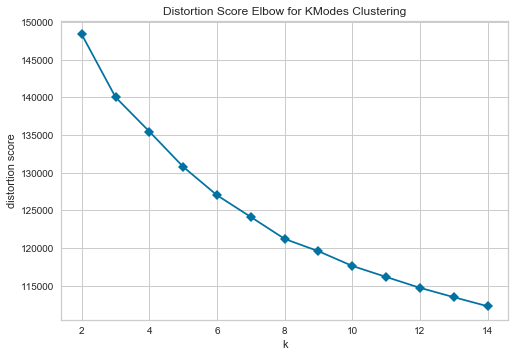

In [13]:
model = KModes(init='Cao', n_init = 1, n_jobs=-1)
visualizer = KElbowVisualizer(model, k=(2,15), timings = False, locate_elbow = False)
visualizer.fit(obs_symp_true)        # Fit the data to the visualizer
visualizer.show(outpath = "Images/kelbow_kmodes_symptrue.png")

In [ ]:
cost = []
for num_clusters in list(range(1,15)):
    kmode = KModes(n_clusters=num_clusters, init = "Cao", n_init = 1, verbose=1)
    kmode.fit_predict(obs_symp_true)
    cost.append(kmode.cost_)

y = np.array([i for i in range(1,15,1)])
plt.plot(y,cost)
plt.xlabel('Clusters')
plt.ylabel('Cost')
plt.show()

### WITH PCA 

In [32]:
from sklearn.decomposition import PCA

pca = PCA(.70)
data_red = pca.fit_transform(observations)
print(pca.n_components_)

11


In [33]:
def plot_several(x_data, y_data, colors, labels, xlabel, ylabel, title, savefig = False, figname = ''):
    fig, ax = plt.subplots()
    plt.xlabel(xlabel, fontsize = 9)
    plt.ylabel(ylabel, fontsize = 9)
    ax.set_title(title, fontsize = 11)
    for i in range(x_data.shape[1]):
        plt.plot(x_data[:,i], y_data[:,i], label = labels[i])
    leg = ax.legend()
    if savefig: plt.savefig(figname, dpi=300, bbox_inches='tight')
    plt.show()

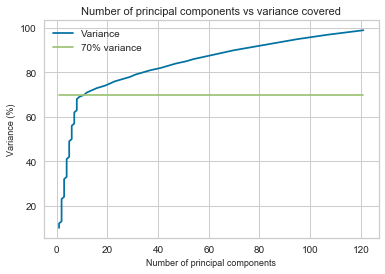

In [34]:
i=0
percento_range = np.arange(0.1,1,0.01)
n_comp = np.zeros(len(percento_range))
for percento in percento_range:
    pca = PCA(percento)
    pca.fit(observations)
    n_comp[i] = pca.n_components_
    i = i+1

plot_several(np.hstack((n_comp[:,None], n_comp[:,None])), 100*np.hstack((percento_range[:,None], percento_range[-1-29]*np.ones(len(percento_range))[:,None])), ['r-', 'g-'], ['Variance', '70% variance'], 'Number of principal components', 'Variance (%)', 'Number of principal components vs variance covered', savefig = True, figname = 'PCA_analysis')

In [35]:
from kneed import KneeLocator

In [36]:
kn = KneeLocator(n_comp, percento_range, curve='concave', direction='increasing')
n_comp = int(kn.knee)
n_comp

12

In [38]:
pca = PCA(n_components = n_comp)
data_red = pca.fit_transform(observations)
print(pca.n_components_)

12


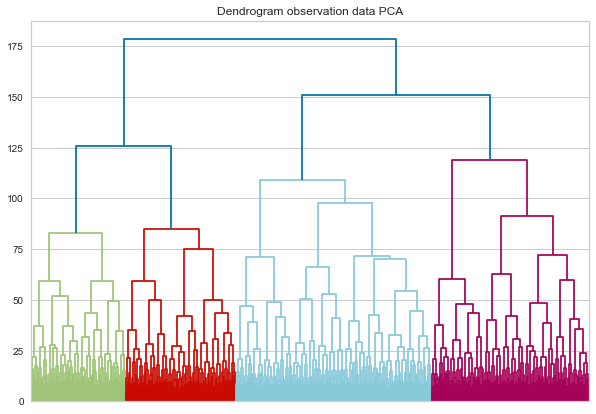

In [22]:
plt.figure(figsize=(10, 7))
plt.title("Dendrogram observation data PCA")
dend = shc.dendrogram(shc.linkage(data_red, method='ward'))
plt.xticks([])
plt.savefig('Images/dendrogram_obs_PCA')
plt.show()

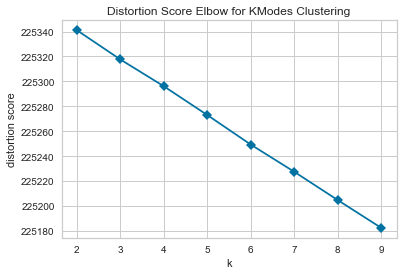

In [24]:
model = KModes(init='Cao', n_jobs=-1)
visualizer = KElbowVisualizer(model, k=(2,10), timings = False, locate_elbow = False)
visualizer.fit(data_red)        # Fit the data to the visualizer
visualizer.show(outpath = "Images/kelbow_kmodes_PCA.png")

### FEATURE IMPORTANCE

In [ ]:
# target = labels 
# data = observations

In [ ]:
data = np.append(observations, labels[:,None], 1)
data.shape

#target = data[:,128]

In [ ]:
clf = RandomForestClassifier(n_estimators=130, random_state=0)
clf.fit(data[:,:128], data[:,128])

#clf_cv = cross_validate(clf, data[:,:128], data[:,128], cv = 5, return_estimator = True)

In [ ]:
k = 10
kf = KFold(n_splits=k, shuffle = True)
rfc = RandomForestClassifier()
count = 1

X = data[:,:128]
y = data[:,128]

imp_sorted_ = {}
for train, _ in kf.split(X, y):
    rfc.fit(X[train, :], y[train])
    
    for key, value in enumerate(rfc.feature_importances_):    
        imp_sorted_[key] = imp_sorted_.get(key, 0) + value

feature_imp = pd.DataFrame.from_dict(imp_sorted_, orient = 'index', columns = ['avg_imp'])
feature_imp['avg_imp'] = feature_imp['avg_imp']/10
feature_imp.sort_values(by = 'avg_imp', ascending = False).head()

# Measuring the effect of actions.


In [35]:
features = pd.read_csv('./medical/historical_X.dat', header=None, sep=" ").values
actions = pd.read_csv('./medical/historical_A.dat', header=None, sep=" ").values
outcome = pd.read_csv('./medical/historical_Y.dat', header=None, sep=" ").values
observations = features[:, :128]
labels = features[:,128] + features[:,129]*2

In [ ]:
# Use bootstrap on the historical dataset to estimate effectiveness of the utility
n = features.shape[0]
num_samples = 1000

eff_placebo = []
eff_treatment = []

for bootstraps in range(num_samples):
    randlist = np.random.randint(n, size=n)
    sample_features = features[randlist]
    sample_actions = actions[randlist]
    sample_outcome = outcome[randlist]
    labels = sample_features[:,128] + sample_features[:,129]*2 # symptoms
        
    placebo_success = []
    total_placebo = []
    
    treatment_success = []
    total_treatment = []

    
    for i in range(len(sample_features)):

    # Placebo effectiveness 
        if labels[i] != 0 and sample_actions[i] == 0:
            total_placebo.append([i])
        if labels[i] != 0 and sample_actions[i] == 0 and sample_outcome[i] == 1: 
            placebo_success.append(sample_features[i])
    
    # Active treatment effectiveness
        if sample_actions[i] == 1:
            total_treatment.append([i])            
        if labels[i] != 0 and sample_actions[i] == 1 and sample_outcome[i] == 1: 
            treatment_success.append(sample_features[i])
    
    eff_placebo.append((len(placebo_success)/len(total_placebo))*100)
    eff_treatment.append((len(treatment_success)/len(total_treatment))*100)

print('Efficiency of the placebo: %0.3f (+/- %0.3f)' % (np.mean(eff_placebo), np.std(eff_placebo)*2))
print('Efficiency of the treatment: %0.3f (+/- %0.3f)' % (np.mean(eff_treatment), np.std(eff_treatment)*2))

fig, ax = plt.subplots(ncols = 2, figsize = (10,5))
sns.distplot(eff_placebo, ax=ax[0], bins = 20)
ax[0].set_title('Efficiency placebo')
ax[0].set_xlabel('efficiency')
sns.distplot(eff_treatment, ax=ax[1], bins = 20)
ax[1].set_title('Efficiency active treatment')
ax[1].set_xlabel('efficiency')
fig.savefig('Images/efficiency_hists.png')

In [26]:
feat = pd.DataFrame(features)

In [30]:
duplicates = feat[feat.duplicated()]
duplicates

,0,1,2,3,4,5,6,7,8,9,...,120,121,122,123,124,125,126,127,128,129


# Utility of the historical data and the recommenders 

In [ ]:
pca = PCA(.70)
obs_red = pca.fit_transform(observations)
feat_red = np.append(obs_red, labels[:,None], 1)
feat_red.shape

## The recommenders

### Historical recommender

In [ ]:
class NNDoctor_hist:
    def __init__(self, 
                 n_actions=1, 
                 n_outcomes=1, 
                 layer_sizes=[64, 16],
                 batch_size=5,
                 epochs=5,
                 optimizer="sgd",
                 loss="binary_crossentropy",
                 alpha = 0.0001):
        self.n_actions = n_actions
        self.n_outcomes = n_outcomes
        self.reward = self._default_reward
        self.layer_sizes = layer_sizes
        self.batch_size = batch_size
        self.epochs = epochs
        self.optimizer = optimizer
        self.loss = loss
        self.alpha = alpha
        
    def _default_reward(self, action, outcome):
        return -0.1*action + outcome
        
    def get_params(self, deep=True):
        return {k: v for k, v in self.__dict__.items() if not callable(v)}

    def set_params(self, **parameters):
        for parameter, value in parameters.items():
            setattr(self, parameter, value)
        return self

    def predict_proba(self, X):
        return self.model.predict(X)

    def fit(self, X, y):
        self.model = self.build_network(X, y)
        self.model.fit(X, y, epochs=self.epochs, batch_size=self.batch_size, verbose=0)

    def predict(self, Xtest):
        return self.model.predict(Xtest)
    
    def predict_classes(self, X):
        return self.model.predict_classes(X)
    
    def build_network(self, X, y):
        model = Sequential()
        for layer_size in self.layer_sizes:
            model.add(Dense(layer_size, activation='elu',kernel_regularizer=regularizers.l2(self.alpha)))
        model.add(Dense(self.n_outcomes, activation='sigmoid'))
        model.compile(loss=self.loss,
                      optimizer=self.optimizer,
                      metrics=['accuracy'])
        return model
    
    def score(self, X, y):
        return (self.model.predict(X)**2 - y**2).mean()
    
    
# fit on actions instead of outcome

class HistoricalRecommender:

    model = None

    def __init__(self, n_actions, n_outcomes):
        self.n_actions = n_actions
        self.n_outcomes = n_outcomes
        self.reward = self._default_reward

    def _default_reward(self, action, outcome):
        return -0.1*action + outcome

    def set_reward(self, reward):
        self.reward = reward

    def fit_treatment_outcome(self, data, actions, outcome):
        print("Fitting treatment outcomes")
        param_grid = {'layer_sizes': [[32, 16], [64, 16]],
        'batch_size': [5, 10],
        'epochs': [1, 5],
        'optimizer': ['Adam', 'sgd'],
        'loss': ['mse'],
        'alpha': [0.001, 0.0001]}
        #self.model = GridSearchCV(NNDoctor_hist(), param_grid, cv=10, n_jobs=4)
        self.model = NNDoctor_hist(n_actions=self.n_actions, n_outcomes=self.n_outcomes)
        self.model.fit(data, actions)
        #print(self.model.best_params_)
        return self.model

    def estimate_utility(self, data, actions, outcome, policy=None):
        if policy is None:
            return self.reward(actions, outcome).mean()
        else:
            policy_actions = np.array([policy.recommend(x) for x in data])
            #predicted_outcomes = self.model.predict(data)
            return self.reward(policy_actions, outcome).mean() #behind outcome .reshape(1,-1)

    def predict_proba(self, data, treatment):
        #predictions = self.model.predict(np.concatenate((data, [treatment])).reshape(1,-1)).ravel()
        pred = self.model.predict(data)
        return pred

    def predict_classes(self, data, treatment):
        #predictions = self.model.predict(np.concatenate((data, [treatment])).reshape(1,-1)).ravel()
        predictions_classes = self.model.predict_classes(data)
        return predictions_classes

    def get_action_probabilities(self, user_data):
        #print("Recommending")
        predictions = []
        for a in range(self.n_actions):
            #estimated_outcome = self.model.predict(np.concatenate((user_data, [a])).reshape(1,-1))[0][0]
            estimated_outcome = self.model.predict(user_data.reshape(1,-1))[0][0]
            estimated_reward = self.reward(a, estimated_outcome)
            predictions.append(estimated_reward)
        return np.exp(predictions)/np.sum(np.exp(predictions))

    def recommend(self, user_data):
        return np.asscalar(self.model.predict_classes(user_data.reshape(1,-1)))
        #return np.argmax(self.get_action_probabilities(user_data))

    def observe(self, user, action, outcome):
        return None

    def final_analysis(self):
        return None

### Improved recommender

In [ ]:
class NNDoctor_imp:
    def __init__(self, 
                 n_actions=1, 
                 n_outcomes=1, 
                 layer_sizes=[64, 16],
                 batch_size=5,
                 epochs=5,
                 optimizer="adam",
                 loss="binary_crossentropy",
                 alpha = 0.0001):
        self.n_actions = n_actions
        self.n_outcomes = n_outcomes
        self.reward = self._default_reward
        self.layer_sizes = layer_sizes
        self.batch_size = batch_size
        self.epochs = epochs
        self.optimizer = optimizer
        self.loss = loss
        self.alpha = alpha
        
    def _default_reward(self, action, outcome):
        return -0.1*action + outcome
        
    def get_params(self, deep=True):
        return {k: v for k, v in self.__dict__.items() if not callable(v)}

    def set_params(self, **parameters):
        for parameter, value in parameters.items():
            setattr(self, parameter, value)
        return self

    def predict_proba(self, X):
        return self.model.predict(X)

    def fit(self, X, y):
        self.model = self.build_network(X, y)
        self.model.fit(X, y, epochs=self.epochs, batch_size=self.batch_size, verbose=0)

    def predict(self, Xtest):
        return self.model.predict(Xtest)
    
    def predict_classes(self, X):
        return self.model.predict_classes(X)
    
    def build_network(self, X, y):
        model = Sequential()
        for layer_size in self.layer_sizes:
            model.add(Dense(layer_size, activation='elu',kernel_regularizer=regularizers.l2(self.alpha)))
        model.add(Dense(self.n_outcomes, activation='sigmoid'))
        model.compile(loss=self.loss,
                      optimizer=self.optimizer,
                      metrics=['accuracy'])
        return model
    
    def score(self, X, y):
        return (self.model.predict(X)**2 - y**2).mean()


class NNRecommender:

    #################################
    # Initialise
    #
    # Set the recommender with a default number of actions and outcomes.  This is
    # because the number of actions in historical data can be
    # different from the ones that you can take with your policy.
    model = None
    
    def __init__(self, n_actions, n_outcomes):
        self.n_actions = n_actions
        self.n_outcomes = n_outcomes
        self.reward = self._default_reward

    ## By default, the reward is just equal to the outcome, as the actions play no role.
    def _default_reward(self, action, outcome):
        return -0.1*action + outcome

    # Set the reward function r(a, y)
    def set_reward(self, reward):
        self.reward = reward
    
    ##################################
    # Fit a model from patient data.
    #
    # This will generally speaking be an
    # unsupervised model. Anything from a Gaussian mixture model to a
    # neural network is a valid choice.  However, you can give special
    # meaning to different parts of the data, and use a supervised
    # model instead.
    def fit_data(self, data):
        print("Preprocessing data")
        return None

    def train_model(self, X, a, y):
        param_grid = {'layer_sizes': [[32, 16], [64, 16]],
        'batch_size': [5, 10],
        'epochs': [1, 5],
        'optimizer': ['Adam', 'sgd'],
        'loss': ['mse'],
        'alpha': [0.001, 0.0001]}
        #self.model = GridSearchCV(NNDoctor_imp(), param_grid, cv=10, n_jobs=4)
        self.model = NNDoctor_imp()
        self.model.fit(np.concatenate((X, a), axis=1), y)
        #print(self.model.best_params_)

    ## Fit a model from patient data, actions and their effects
    ## Here we assume that the outcome is a direct function of data and actions
    ## This model can then be used in estimate_utility(), predict_proba() and recommend()
    def fit_treatment_outcome(self, data, actions, outcome):
        print("Fitting treatment outcomes")
        self.train_model(data, actions, outcome)
        return self.model

    ## Estimate the utility of a specific policy from historical data (data, actions, outcome),
    ## where utility is the expected reward of the policy.
    ##
    ## If policy is not given, simply use the average reward of the observed actions and outcomes.
    ##
    ## If a policy is given, then you can either use importance
    ## sampling, or use the model you have fitted from historical data
    ## to get an estimate of the utility.
    ##
    ## The policy should be a recommender that implements get_action_probability()
    def estimate_utility(self, data, actions, outcome, policy=None):
        if policy is None:
            return self.reward(actions, outcome).mean()
        else:
            #predictions_ones = self.model.predict(np.concatenate((data, np.ones(len(data)).reshape(-1,1)), axis = 1))
            #predictions_zeros = self.model.predict(np.concatenate((data, np.zeros(len(data)).reshape(-1,1)), axis = 1))
            #predictions = np.concatenate((predictions_zeros, predictions_ones), axis=1)
            #policy_actions = np.array([policy.get_action_probabilities(x) for x in data])
            policy_actions = np.array([policy.recommend(x) for x in data])
            predicted_outcomes = self.model.predict(np.concatenate((data, policy_actions.reshape(-1,1)), axis=1))
            return self.reward(policy_actions, predicted_outcomes.reshape(1,-1)).mean()
            #print(policy_actions)
            #res_matrix = np.dot(predictions.T, policy_actions)
            #print(res_matrix)
            #return (-0.1*policy_actions.sum() + (res_matrix[0][0] + res_matrix[1][1])) / len(data)

    # Return a distribution of effects for a given person's data and a specific treatment.
    # This should be an numpy.array of length self.n_outcomes
    def predict_proba(self, data, treatment):
        predictions = self.model.predict(np.concatenate((data, [treatment])).reshape(1,-1)).ravel()
        return predictions
    
    def predict_classes(self, data, treatment):
        predictions = self.model.predict_classes(np.concatenate((data, [treatment])).reshape(1,-1)).ravel()
        return predictions_classes

    # Return a distribution of recommendations for a specific user datum
    # This should a numpy array of size equal to self.n_actions, summing up to 1
    def get_action_probabilities(self, user_data):
        #print("Recommending")
        predictions = []
        for a in range(self.n_actions):
            estimated_outcome = self.model.predict(np.concatenate((user_data, [a])).reshape(1,-1))[0][0]
            estimated_reward = self.reward(a, estimated_outcome)
            predictions.append(estimated_reward)
        return np.exp(predictions)/np.sum(np.exp(predictions))
    
    def estimate_historic_utility(self, data, actions, outcome):
        estimated_outcome = self.model.predict(np.concatenate((data, actions), axis=1))
        #outcome_prob = 1/(1 + np.exp(0.5-estimated_outcome))
        return self.reward(actions, estimated_outcome).mean()

    # Return recommendations for a specific user datum
    # This should be an integer in range(self.n_actions)
    def recommend(self, user_data):
        return np.argmax(self.get_action_probabilities(user_data))

    # Observe the effect of an action. This is an opportunity for you
    # to refit your models, to take the new information into account.
    def observe(self, user, action, outcome):
        return None

    # After all the data has been obtained, do a final analysis. This can consist of a number of things:
    # 1. Recommending a specific fixed treatment policy
    # 2. Suggesting looking at specific genes more closely
    # 3. Showing whether or not the new treatment might be better than the old, and by how much.
    # 4. Outputting an estimate of the advantage of gene-targeting treatments versus the best fixed treatment
    def final_analysis(self):
        return None

In [ ]:
nn_hist = HistoricalRecommender(n_actions = len(np.unique(actions)), n_outcomes = outcome.shape[1])
nn_imp = NNRecommender(len(np.unique(actions)), outcome.shape[1])

nn_hist_red = HistoricalRecommender(n_actions = len(np.unique(actions)), n_outcomes = outcome.shape[1])
nn_imp_red = NNRecommender(len(np.unique(actions)), outcome.shape[1])
print(len(np.unique(actions)))

f_train, f_test, a_train, a_test, o_train, o_test = train_test_split(features, actions, outcome, test_size=.3)

f_train_red, f_test_red, a_train, a_test, o_train, o_test = train_test_split(feat_red, actions, outcome, test_size=.3)

In [ ]:
# fit the data on the features and the action (outcome is disregarded here)

nn_hist.fit_treatment_outcome(f_train, a_train, o_train)
nn_imp.fit_treatment_outcome(f_train, a_train, o_train)

nn_hist_red.fit_treatment_outcome(f_train_red, a_train, o_train)
nn_imp_red.fit_treatment_outcome(f_train_red, a_train, o_train)

See how well the model is actually doing

In [ ]:
pred_red = nn_hist_red.predict_classes(f_test_red, a_test)

unique, counts = np.unique(pred_red, return_counts=True)
print('prediction:', dict(zip(unique, counts)))

unique, counts = np.unique(a_test, return_counts=True)
print('actual:', dict(zip(unique, counts)))

print(classification_report(a_test, pred_red))

We first implement estimate_utility to get the utility for each policy. We compare without and with pca. 

In [ ]:
print(nn_hist.estimate_utility(features, actions, outcome))
print(nn_hist.estimate_utility(features, actions, outcome, policy = nn_hist))
print(nn_imp.estimate_utility(features, actions, outcome, policy = nn_imp))

print('with pca:')
print(nn_hist.estimate_utility(features, actions, outcome))
print(nn_hist_red.estimate_utility(feat_red, actions, outcome, policy = nn_hist_red))
print(nn_imp_red.estimate_utility(feat_red, actions, outcome, policy = nn_imp_red))

Next we calculate the utility for the historical data, the historical recommender and the improved recommender on the test set of the historical data for the reduced dataset.

In [ ]:
n = f_test_red.shape[0]
num_samples = 100

utils = []
utils_hist = []
utils_imp = []

for i in range(num_samples):
    randlist = np.random.randint(n, size=n)
    sample_features = f_test_red[randlist]
    sample_actions = a_test[randlist]
    sample_outcome = o_test[randlist]
    
    utils.append(nn_hist_red.estimate_utility(sample_features, sample_actions, sample_outcome))
    utils_hist.append(nn_hist_red.estimate_utility(sample_features, sample_actions, sample_outcome, policy = nn_hist_red))
    utils_imp.append(nn_imp_red.estimate_utility(sample_features, sample_actions, sample_outcome, policy = nn_imp_red))
    print(i)


fig1, ax = plt.subplots(figsize = (15, 5), ncols = 3)
sns.distplot(utils, ax = ax[0])
sns.distplot(utils_hist, ax = ax[1])
sns.distplot(utils_imp, ax = ax[2])
fig1.suptitle('Histograms of the utility')
ax[0].set_title('Historic data')
ax[1].set_title('Historic policy')
ax[2].set_title('Improved policy')
fig1.savefig('./Images/histograms_datared.png')
plt.show()
plt.clf()

print("mean utility: {0:.4f}".format(np.mean(utils)))
print("Utility std: {0:.4f}".format(np.std(utils)))

print("mean utility hist: {0:.4f}".format(np.mean(utils_hist)))
print("Utility std hist: {0:.4f}".format(np.std(utils_hist)))

print("mean utility imp: {0:.4f}".format(np.mean(utils_imp)))
print("Utility std imp: {0:.4f}".format(np.std(utils_imp)))

# Feature importance PCA

We get the feature importances according to the pca

In [ ]:
n_pcs = pca.components_.shape[0]

most_important = [np.abs(pca.components_[i]).argsort()[-5:][::-1] for i in range(n_pcs)]
dic = {'PC{}'.format(i): most_important[i] for i in range(n_pcs)}

df = pd.DataFrame(dic.items(), columns = ['PC', 'Important genes'])

df['Explained variance'] = pca.explained_variance_ratio_